# Can we forecast the S&P returns?
Both the investment community and private investors alike have always had an interest in forecasting future market trends, particularly the return of the S&P index which is a market cap weighted index of the top 500 companies in the United States stock market. In order to forecast the index, we will use different methodologies and regression models such as ARIMA, VAR, Ridge and to end will implement a Neural Network to test what is the optimal forecasting model for the index.

## 01 Introduction 
As both an investor and a financial risk analyst, I have had a lot of exposure to analytics that are dependent on the S&P index over the course of the past couple of years, therefore I have an intimate interest in the subject matter. However, as it relates to the utility of this project, I believe that any stakeholder involved in risk management, asset management or wealth management would find this project and its related outcomes to be useful. 

To perform this analysis we will also use the top 5 components of the S&P to set up the vector autor regression, ridge regresssion and the neural network. The top 5 components of the S&P are (in no particular order) Amazon, Facebook, Microsoft, Apple and Alphabet/Google. 

## 02 Import Relevant Modules

In [1]:
# import relevant modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.core.interactiveshell import InteractiveShell #This package and the command below allow for the Jupyter notebook
#to print all the outputs and NOT just the final row
InteractiveShell.ast_node_interactivity = "all" #this command allows all outputs to be p

## 03 Data Wrangling
All the data was sourced from Yahoo Finance (https://finance.yahoo.com/) with a 5 year lookback, all the way back to January 2nd 2015 (since 01/01/2015 is a holiday and the market is closed). We will be importing the open, high, low, close and volume for each one of the top 5 components and the S&P index itself below.

In [2]:
#Import GSPC = S&P Index
df_GSPC = pd.read_csv('GSPC.csv')
df_GSPC['ticker'] = 'GSPC'
#Import GOOG = Google
df_GOOG = pd.read_csv('GOOG.csv')
df_GOOG['ticker'] = 'GOOG'
#Import MSFT = Microsoft
df_MSFT = pd.read_csv('MSFT.csv')
df_MSFT['ticker'] = 'MSFT'
#Import AMZN = Amazon
df_AMZN = pd.read_csv('AMZN.csv')
df_AMZN['ticker'] = 'AMZN'
#Import FB = Facebook
df_FB = pd.read_csv('FB.csv')
df_FB['ticker'] = 'FB'
#Import AAPL = Apple
df_AAPL = pd.read_csv('AAPL.csv')
df_AAPL['ticker'] = 'AAPL'

One of the key issues behind the downloads from Yahoo finance is that none of the datasets come with column headers that indicate what index/stock they belong to, therefore for clarity and data integrity issues I will be renaming the columns below as follows

In [3]:
# To ensure all columns have unique names I will be update the column names
df_AAPL.columns = [x + '_AAPL' for x in df_AAPL.columns]
df_AMZN.columns = [x + '_AMZN' for x in df_AMZN.columns]
df_MSFT.columns = [x + '_MSFT' for x in df_MSFT.columns]
df_FB.columns = [x + '_FB' for x in df_FB.columns]
df_GOOG.columns = [x + '_GOOG' for x in df_GOOG.columns]
df_GSPC.columns = [x + '_GSPC' for x in df_GSPC.columns]
df_AAPL.rename(columns = {'Date_AAPL': 'Date'}, inplace = True)
df_AMZN.rename(columns = {'Date_AMZN': 'Date'}, inplace = True)
df_MSFT.rename(columns = {'Date_MSFT': 'Date'}, inplace = True)
df_FB.rename(columns = {'Date_FB': 'Date'}, inplace = True)
df_GOOG.rename(columns = {'Date_GOOG': 'Date'}, inplace = True)
df_GSPC.rename(columns = {'Date_GSPC': 'Date'}, inplace = True)

In [4]:
# Verify the change was made 
df_GSPC.head(1)
df_AAPL.head(1)
df_AMZN.head(1)
df_MSFT.head(1)
df_FB.head(1)
df_GOOG.head(1)

,Date,Open_GSPC,High_GSPC,Low_GSPC,Close_GSPC,Adj Close_GSPC,Volume_GSPC,ticker_GSPC
0,2015-01-02,2058.899902,2072.360107,2046.040039,2058.199951,2058.199951,2708700000,GSPC


,Date,Open_AAPL,High_AAPL,Low_AAPL,Close_AAPL,Adj Close_AAPL,Volume_AAPL,ticker_AAPL
0,1/2/2015,27.8475,27.860001,26.8375,27.3325,24.898552,212818400,AAPL


,Date,Open_AMZN,High_AMZN,Low_AMZN,Close_AMZN,Adj Close_AMZN,Volume_AMZN,ticker_AMZN
0,1/2/2015,312.579987,314.75,306.959991,308.519989,308.519989,2783200,AMZN


,Date,Open_MSFT,High_MSFT,Low_MSFT,Close_MSFT,Adj Close_MSFT,Volume_MSFT,ticker_MSFT
0,1/2/2015,46.66,47.419998,46.540001,46.759998,41.539135,27913900,MSFT


,Date,Open_FB,High_FB,Low_FB,Close_FB,Adj Close_FB,Volume_FB,ticker_FB
0,1/2/2015,78.580002,78.93,77.699997,78.449997,78.449997,18177500,FB


,Date,Open_GOOG,High_GOOG,Low_GOOG,Close_GOOG,Adj Close_GOOG,Volume_GOOG,ticker_GOOG
0,1/2/2015,527.561584,529.815369,522.665039,523.373108,523.373108,1447500,GOOG


Since we will be working with time series, any date variables need to be passed to numeric types using the pandas function to_datetime, this will ensure that when we perform a time series analysis where the indexes will be the dates in our time series all of our models do not throw exceptions

In [5]:
# Change all the dates to date time
df_GSPC['Date'] = pd.to_datetime(df_GSPC['Date']) 
df_GOOG['Date'] = pd.to_datetime(df_GOOG['Date']) 
df_FB['Date'] = pd.to_datetime(df_FB['Date']) 
df_AMZN['Date'] = pd.to_datetime(df_AMZN['Date']) 
df_AAPL['Date'] = pd.to_datetime(df_AAPL['Date']) 
df_MSFT['Date'] = pd.to_datetime(df_MSFT['Date']) 

In [6]:
# Verify the change was made 
df_GSPC.head(1)
df_AAPL.head(1)
df_AMZN.head(1)
df_MSFT.head(1)
df_FB.head(1)
df_GOOG.head(1)

,Date,Open_GSPC,High_GSPC,Low_GSPC,Close_GSPC,Adj Close_GSPC,Volume_GSPC,ticker_GSPC
0,2015-01-02,2058.899902,2072.360107,2046.040039,2058.199951,2058.199951,2708700000,GSPC


,Date,Open_AAPL,High_AAPL,Low_AAPL,Close_AAPL,Adj Close_AAPL,Volume_AAPL,ticker_AAPL
0,2015-01-02,27.8475,27.860001,26.8375,27.3325,24.898552,212818400,AAPL


,Date,Open_AMZN,High_AMZN,Low_AMZN,Close_AMZN,Adj Close_AMZN,Volume_AMZN,ticker_AMZN
0,2015-01-02,312.579987,314.75,306.959991,308.519989,308.519989,2783200,AMZN


,Date,Open_MSFT,High_MSFT,Low_MSFT,Close_MSFT,Adj Close_MSFT,Volume_MSFT,ticker_MSFT
0,2015-01-02,46.66,47.419998,46.540001,46.759998,41.539135,27913900,MSFT


,Date,Open_FB,High_FB,Low_FB,Close_FB,Adj Close_FB,Volume_FB,ticker_FB
0,2015-01-02,78.580002,78.93,77.699997,78.449997,78.449997,18177500,FB


,Date,Open_GOOG,High_GOOG,Low_GOOG,Close_GOOG,Adj Close_GOOG,Volume_GOOG,ticker_GOOG
0,2015-01-02,527.561584,529.815369,522.665039,523.373108,523.373108,1447500,GOOG


For the purposes of our analysis we will be merging all of our data frames together for ease of access. Our df variable will contain our full dataset which will be referenced throughout the project.

In [7]:
# Merge all dataframes into one 
df = df_GSPC
df = df.merge(df_AMZN, how='inner', on='Date')
df = df.merge(df_AAPL, how='inner', on='Date')
df = df.merge(df_GOOG, how='inner', on='Date')
df = df.merge(df_FB, how='inner', on='Date')
df = df.merge(df_MSFT, how='inner', on='Date')

Given that time series are highly sensitive to outliers and time frames, we will be using approximately 6 months of data to forecast one since we want to ensure that our model is follow the most recent trends our index has been following. Using extremely long time series can be dangerous since a model may overestimate or underestimate short term returns by favoring old trends

In [8]:
# List of columns in final dataframe
# Reduce the dataframe to data since 2018
df = df[df['Date']> '2020-04-30'] 
df = df.reset_index(drop=True)
df.head()
df.shape
df.columns

,Date,Open_GSPC,High_GSPC,Low_GSPC,Close_GSPC,Adj Close_GSPC,Volume_GSPC,ticker_GSPC,Open_AMZN,High_AMZN,...,Adj Close_FB,Volume_FB,ticker_FB,Open_MSFT,High_MSFT,Low_MSFT,Close_MSFT,Adj Close_MSFT,Volume_MSFT,ticker_MSFT
0,2020-05-01,2869.090088,2869.090088,2821.610107,2830.709961,2830.709961,4753160000,GSPC,2336.800049,2362.439941,...,202.270004,30415600,FB,175.800003,178.639999,174.009995,174.570007,173.211899,39370500,MSFT
1,2020-05-04,2815.010010,2844.239990,2797.850098,2842.739990,2842.739990,4723140000,GSPC,2256.379883,2326.979980,...,205.259995,19250700,FB,174.490005,179.000000,173.800003,178.839996,177.448639,30372900,MSFT
2,2020-05-05,2868.879883,2898.229980,2863.550049,2868.439941,2868.439941,5129590000,GSPC,2340.000000,2351.000000,...,207.070007,21071200,FB,180.619995,183.649994,179.899994,180.759995,179.353729,36839200,MSFT
3,2020-05-06,2883.139893,2891.110107,2847.649902,2848.419922,2848.419922,4861920000,GSPC,2329.439941,2357.449951,...,208.470001,21857000,FB,182.080002,184.199997,181.630005,182.539993,181.119873,32139300,MSFT
4,2020-05-07,2878.260010,2901.919922,2876.479980,2881.189941,2881.189941,5164640000,GSPC,2374.780029,2376.000000,...,211.259995,15152000,FB,184.169998,184.550003,182.580002,183.600006,182.171631,28316000,MSFT


(177, 43)

Index(['Date', 'Open_GSPC', 'High_GSPC', 'Low_GSPC', 'Close_GSPC',
       'Adj Close_GSPC', 'Volume_GSPC', 'ticker_GSPC', 'Open_AMZN',
       'High_AMZN', 'Low_AMZN', 'Close_AMZN', 'Adj Close_AMZN', 'Volume_AMZN',
       'ticker_AMZN', 'Open_AAPL', 'High_AAPL', 'Low_AAPL', 'Close_AAPL',
       'Adj Close_AAPL', 'Volume_AAPL', 'ticker_AAPL', 'Open_GOOG',
       'High_GOOG', 'Low_GOOG', 'Close_GOOG', 'Adj Close_GOOG', 'Volume_GOOG',
       'ticker_GOOG', 'Open_FB', 'High_FB', 'Low_FB', 'Close_FB',
       'Adj Close_FB', 'Volume_FB', 'ticker_FB', 'Open_MSFT', 'High_MSFT',
       'Low_MSFT', 'Close_MSFT', 'Adj Close_MSFT', 'Volume_MSFT',
       'ticker_MSFT'],
      dtype='object')

## 04 Exploratory Data Analysis
In this section we will start taking a look at some of the relationships between every variable in our study, some of trends that the S&P index follows, the correlations between the S&P and its constituents, whether or not the data is stationary, whether it follows a random walk, etc. 

In [9]:
# We will first bring the closing prices for each one of the variables in scope
df_closing_prices = df[['Date','Close_GSPC','Close_FB','Close_AMZN','Close_GOOG','Close_AAPL','Close_MSFT']]

<Figure size 1008x576 with 0 Axes>

Text(0.5, 1.0, 'Prices for the S&P and top 5 constituents')

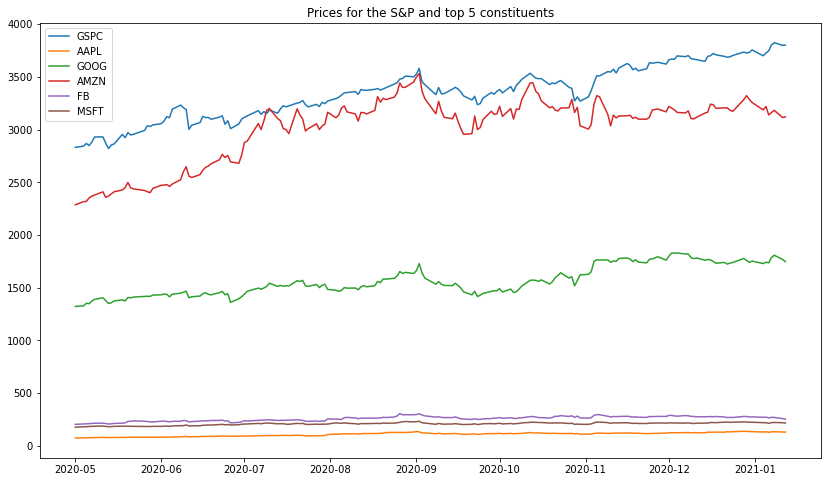

In [10]:
# Graph all trends in absolute terms
plt.figure(figsize=(14,8))
plt.plot(df_closing_prices.Date, df_closing_prices.Close_GSPC, label = "GSPC")
plt.plot(df_closing_prices.Date, df_closing_prices.Close_AAPL, label = "AAPL")
plt.plot(df_closing_prices.Date, df_closing_prices.Close_GOOG, label = "GOOG")
plt.plot(df_closing_prices.Date, df_closing_prices.Close_AMZN, label = "AMZN")
plt.plot(df_closing_prices.Date, df_closing_prices.Close_FB, label = "FB")
plt.plot(df_closing_prices.Date, df_closing_prices.Close_MSFT, label = "MSFT")
plt.legend(loc="upper left")
plt.title('Prices for the S&P and top 5 constituents')
plt.show()

<Figure size 1008x576 with 0 Axes>

Text(0.5, 1.0, 'Absolute daily differences for the S&P and top 5 constituents')

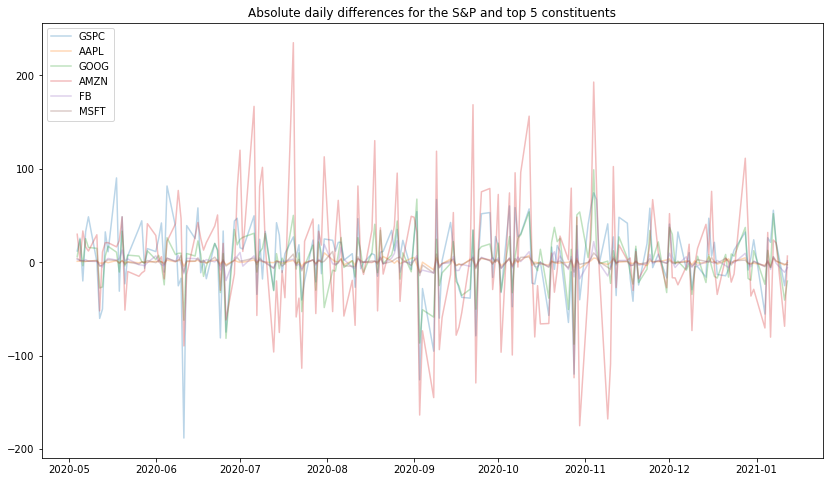

In [11]:
# Graph all trends in terms of differences
plt.figure(figsize=(14,8))
plt.plot(df_closing_prices.Date, df_closing_prices.Close_GSPC.diff(), alpha=0.3, label = "GSPC")
plt.plot(df_closing_prices.Date, df_closing_prices.Close_AAPL.diff(), alpha=0.3, label = "AAPL")
plt.plot(df_closing_prices.Date, df_closing_prices.Close_GOOG.diff(), alpha=0.3, label = "GOOG")
plt.plot(df_closing_prices.Date, df_closing_prices.Close_AMZN.diff(), alpha=0.3, label = "AMZN")
plt.plot(df_closing_prices.Date, df_closing_prices.Close_FB.diff(), alpha=0.3, label = "FB")
plt.plot(df_closing_prices.Date, df_closing_prices.Close_MSFT.diff(), alpha=0.3, label = "MSFT")
plt.legend(loc="upper left")
plt.title('Absolute daily differences for the S&P and top 5 constituents')
plt.show()

<Figure size 1008x576 with 0 Axes>

Text(0.5, 1.0, 'Percentage changes for the S&P and top 5 constituents')

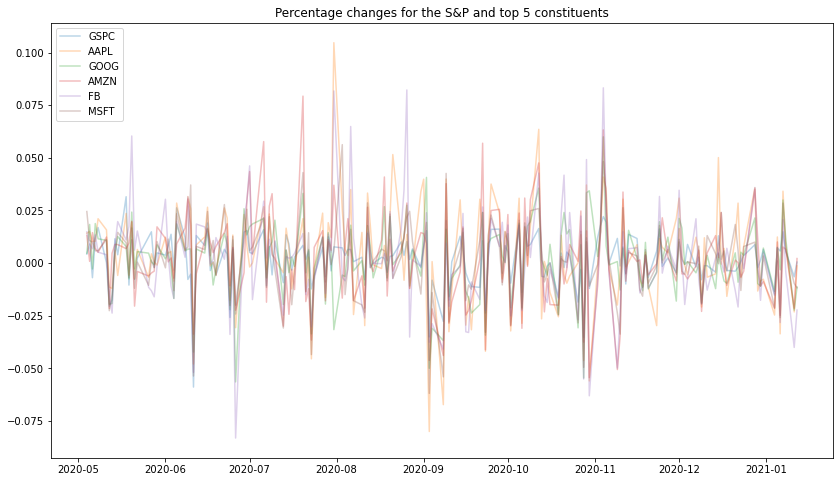

In [12]:
# Graph all trends in terms of percentage changes
plt.figure(figsize=(14,8))
plt.plot(df_closing_prices.Date, df_closing_prices.Close_GSPC.pct_change(), alpha=0.3, label = "GSPC")
plt.plot(df_closing_prices.Date, df_closing_prices.Close_AAPL.pct_change(), alpha=0.3, label = "AAPL")
plt.plot(df_closing_prices.Date, df_closing_prices.Close_GOOG.pct_change(), alpha=0.3, label = "GOOG")
plt.plot(df_closing_prices.Date, df_closing_prices.Close_AMZN.pct_change(), alpha=0.3, label = "AMZN")
plt.plot(df_closing_prices.Date, df_closing_prices.Close_FB.pct_change(), alpha=0.3, label = "FB")
plt.plot(df_closing_prices.Date, df_closing_prices.Close_MSFT.pct_change(), alpha=0.3, label = "MSFT")
plt.legend(loc="upper left")
plt.title('Percentage changes for the S&P and top 5 constituents')
plt.show()

As we can see in the graph above, the overall trend and variance that our returns follow is relatively stationary with the exception of few outliers such as FB's and AAPL's. Additionally, the mean of the returns appears to be centers around 0 for most of our variables which is a great indicator whenever once is preparing data to be used in autoregression models!  

<Figure size 1008x576 with 0 Axes>

(array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         1.,  0.,  0.,  0.,  2.,  0.,  2.,  3.,  4.,  9., 19., 28., 34.,
        31., 25., 14.,  2.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]),
 array([-1.25000000e-01, -1.20000000e-01, -1.15000000e-01, -1.10000000e-01,
        -1.05000000e-01, -1.00000000e-01, -9.50000000e-02, -9.00000000e-02,
        -8.50000000e-02, -8.00000000e-02, -7.50000000e-02, -7.00000000e-02,
        -6.50000000e-02, -6.00000000e-02, -5.50000000e-02, -5.00000000e-02,
        -4.50000000e-02, -4.00000000e-02, -3.50000000e-02, -3.00000000e-02,
        -2.50000000e-02, -2.00000000e-02, -1.50000000e-02, -1.00000000e-02,
        -5.00000000e-03,  1.11022302e-16,  5.00000000e-03,  1.00000000e-02,
         1.50000000e-02,  2.00000000e-02,  2.50000000e-02,  3.00000000e-02,
         3.50000000e-02,  4.00000000e-02,  4.50000000e-02,  5.00000000e-02,
         5.50000000e-02,  6.00000000e

(array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,
         1.,  0.,  3.,  1.,  0.,  5.,  6.,  5.,  5., 10., 18., 20., 16.,
        17., 18., 11., 10.,  7., 10.,  6.,  1.,  0.,  2.,  0.,  1.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.]),
 array([-1.25000000e-01, -1.20000000e-01, -1.15000000e-01, -1.10000000e-01,
        -1.05000000e-01, -1.00000000e-01, -9.50000000e-02, -9.00000000e-02,
        -8.50000000e-02, -8.00000000e-02, -7.50000000e-02, -7.00000000e-02,
        -6.50000000e-02, -6.00000000e-02, -5.50000000e-02, -5.00000000e-02,
        -4.50000000e-02, -4.00000000e-02, -3.50000000e-02, -3.00000000e-02,
        -2.50000000e-02, -2.00000000e-02, -1.50000000e-02, -1.00000000e-02,
        -5.00000000e-03,  1.11022302e-16,  5.00000000e-03,  1.00000000e-02,
         1.50000000e-02,  2.00000000e-02,  2.50000000e-02,  3.00000000e-02,
         3.50000000e-02,  4.00000000e-02,  4.50000000e-02,  5.00000000e-02,
         5.50000000e-02,  6.00000000e

(array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         1.,  2.,  0.,  1.,  1.,  5.,  0.,  6., 10., 11., 14., 22., 21.,
        29., 18., 17.,  8.,  4.,  3.,  1.,  1.,  0.,  0.,  1.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]),
 array([-1.25000000e-01, -1.20000000e-01, -1.15000000e-01, -1.10000000e-01,
        -1.05000000e-01, -1.00000000e-01, -9.50000000e-02, -9.00000000e-02,
        -8.50000000e-02, -8.00000000e-02, -7.50000000e-02, -7.00000000e-02,
        -6.50000000e-02, -6.00000000e-02, -5.50000000e-02, -5.00000000e-02,
        -4.50000000e-02, -4.00000000e-02, -3.50000000e-02, -3.00000000e-02,
        -2.50000000e-02, -2.00000000e-02, -1.50000000e-02, -1.00000000e-02,
        -5.00000000e-03,  1.11022302e-16,  5.00000000e-03,  1.00000000e-02,
         1.50000000e-02,  2.00000000e-02,  2.50000000e-02,  3.00000000e-02,
         3.50000000e-02,  4.00000000e-02,  4.50000000e-02,  5.00000000e-02,
         5.50000000e-02,  6.00000000e

(array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  2.,  1.,  2.,  2.,  4.,  2., 14.,  9.,  7., 17., 17., 21.,
        24., 16., 10.,  8.,  5.,  5.,  3.,  2.,  1.,  0.,  2.,  1.,  0.,
         0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]),
 array([-1.25000000e-01, -1.20000000e-01, -1.15000000e-01, -1.10000000e-01,
        -1.05000000e-01, -1.00000000e-01, -9.50000000e-02, -9.00000000e-02,
        -8.50000000e-02, -8.00000000e-02, -7.50000000e-02, -7.00000000e-02,
        -6.50000000e-02, -6.00000000e-02, -5.50000000e-02, -5.00000000e-02,
        -4.50000000e-02, -4.00000000e-02, -3.50000000e-02, -3.00000000e-02,
        -2.50000000e-02, -2.00000000e-02, -1.50000000e-02, -1.00000000e-02,
        -5.00000000e-03,  1.11022302e-16,  5.00000000e-03,  1.00000000e-02,
         1.50000000e-02,  2.00000000e-02,  2.50000000e-02,  3.00000000e-02,
         3.50000000e-02,  4.00000000e-02,  4.50000000e-02,  5.00000000e-02,
         5.50000000e-02,  6.00000000e

(array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  1.,
         1.,  1.,  1.,  2.,  2.,  4.,  5.,  9., 11., 11., 12., 19., 26.,
        16., 13., 11., 11.,  4.,  5.,  1.,  2.,  2.,  0.,  0.,  2.,  0.,
         0.,  0.,  3.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]),
 array([-1.25000000e-01, -1.20000000e-01, -1.15000000e-01, -1.10000000e-01,
        -1.05000000e-01, -1.00000000e-01, -9.50000000e-02, -9.00000000e-02,
        -8.50000000e-02, -8.00000000e-02, -7.50000000e-02, -7.00000000e-02,
        -6.50000000e-02, -6.00000000e-02, -5.50000000e-02, -5.00000000e-02,
        -4.50000000e-02, -4.00000000e-02, -3.50000000e-02, -3.00000000e-02,
        -2.50000000e-02, -2.00000000e-02, -1.50000000e-02, -1.00000000e-02,
        -5.00000000e-03,  1.11022302e-16,  5.00000000e-03,  1.00000000e-02,
         1.50000000e-02,  2.00000000e-02,  2.50000000e-02,  3.00000000e-02,
         3.50000000e-02,  4.00000000e-02,  4.50000000e-02,  5.00000000e-02,
         5.50000000e-02,  6.00000000e

(array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,
         0.,  2.,  1.,  1.,  0.,  3.,  4.,  8.,  8., 15., 16., 15., 20.,
        29., 20.,  7., 14.,  6.,  1.,  1.,  2.,  1.,  0.,  1.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]),
 array([-1.25000000e-01, -1.20000000e-01, -1.15000000e-01, -1.10000000e-01,
        -1.05000000e-01, -1.00000000e-01, -9.50000000e-02, -9.00000000e-02,
        -8.50000000e-02, -8.00000000e-02, -7.50000000e-02, -7.00000000e-02,
        -6.50000000e-02, -6.00000000e-02, -5.50000000e-02, -5.00000000e-02,
        -4.50000000e-02, -4.00000000e-02, -3.50000000e-02, -3.00000000e-02,
        -2.50000000e-02, -2.00000000e-02, -1.50000000e-02, -1.00000000e-02,
        -5.00000000e-03,  1.11022302e-16,  5.00000000e-03,  1.00000000e-02,
         1.50000000e-02,  2.00000000e-02,  2.50000000e-02,  3.00000000e-02,
         3.50000000e-02,  4.00000000e-02,  4.50000000e-02,  5.00000000e-02,
         5.50000000e-02,  6.00000000e

Text(0.5, 1.0, 'Histogram for the S&P and top 5 constituents returns')

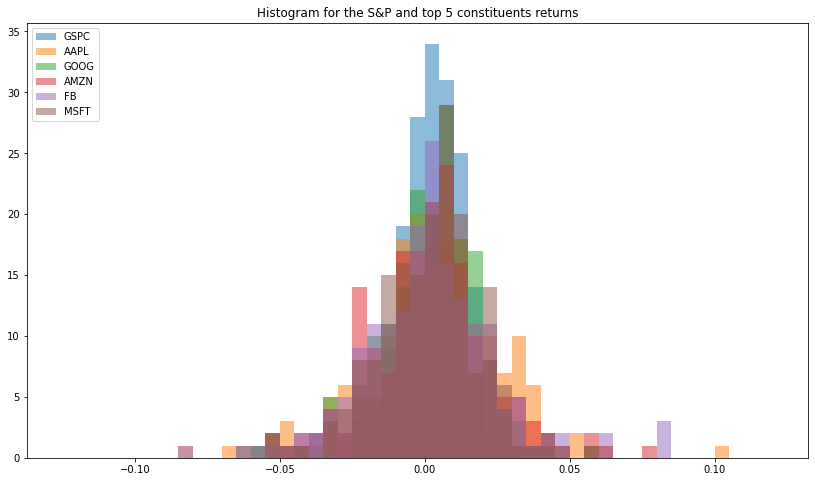

In [13]:
# Graph all trends in terms of differences
bins=np.arange(-0.125,0.125,0.005)
plt.figure(figsize=(14,8))
plt.hist(df_closing_prices.Close_GSPC.pct_change(), alpha=0.5, label = "GSPC", bins=bins)
plt.hist(df_closing_prices.Close_AAPL.pct_change(), alpha=0.5, label = "AAPL", bins=bins)
plt.hist(df_closing_prices.Close_GOOG.pct_change(), alpha=0.5, label = "GOOG", bins=bins)
plt.hist(df_closing_prices.Close_AMZN.pct_change(), alpha=0.5, label = "AMZN", bins=bins)
plt.hist(df_closing_prices.Close_FB.pct_change(), alpha=0.5, label = "FB", bins=bins)
plt.hist(df_closing_prices.Close_MSFT.pct_change(), alpha=0.5, label = "MSFT", bins=bins)
plt.legend(loc="upper left")
plt.title('Histogram for the S&P and top 5 constituents returns')
plt.show()

Our histogram confirms the trends we had seen in the prior graph. Most of our variables have means around 0 and appear to be for the most part normally distributed with few excepions (note the buckets at the tails). With that said, this data defends that our variables are stationary which is a key assumption for us to be able to plot our autoregressive models!

<Figure size 1008x360 with 0 Axes>

Text(0.5, 1.0, 'Historical prices for the S&P')

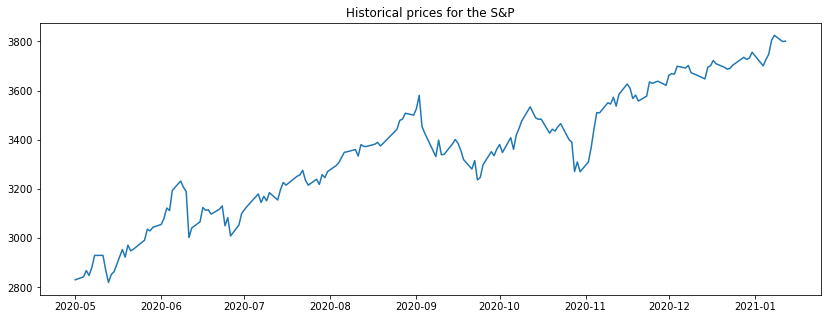

<Figure size 1008x360 with 0 Axes>

Text(0.5, 1.0, 'Absolute daily differences for the S&P')

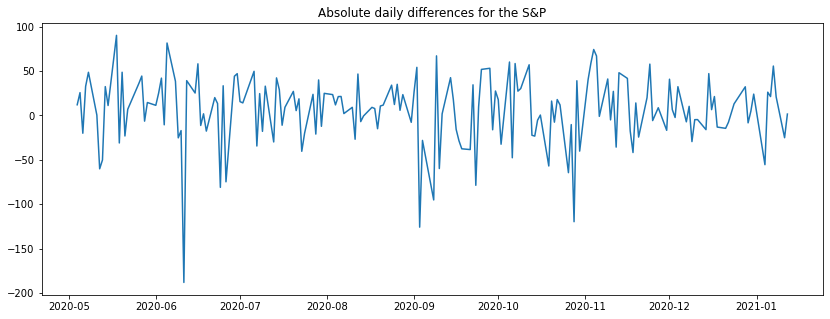

<Figure size 1008x360 with 0 Axes>

Text(0.5, 1.0, 'Daily percentage changes for the S&P')

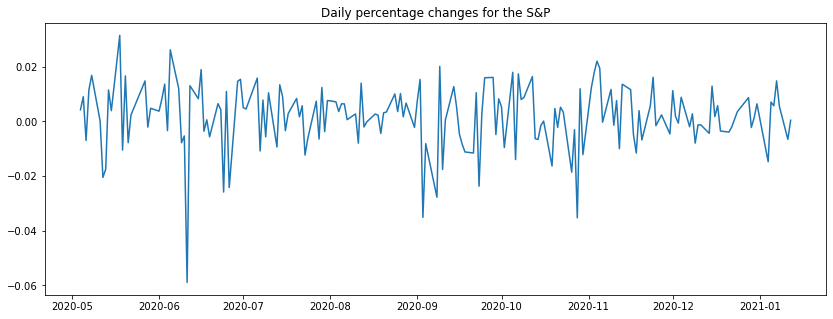

<Figure size 1008x576 with 0 Axes>

(array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         1.,  0.,  0.,  0.,  2.,  0.,  2.,  3.,  4.,  9., 19., 28., 34.,
        31., 25., 14.,  2.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]),
 array([-1.25000000e-01, -1.20000000e-01, -1.15000000e-01, -1.10000000e-01,
        -1.05000000e-01, -1.00000000e-01, -9.50000000e-02, -9.00000000e-02,
        -8.50000000e-02, -8.00000000e-02, -7.50000000e-02, -7.00000000e-02,
        -6.50000000e-02, -6.00000000e-02, -5.50000000e-02, -5.00000000e-02,
        -4.50000000e-02, -4.00000000e-02, -3.50000000e-02, -3.00000000e-02,
        -2.50000000e-02, -2.00000000e-02, -1.50000000e-02, -1.00000000e-02,
        -5.00000000e-03,  1.11022302e-16,  5.00000000e-03,  1.00000000e-02,
         1.50000000e-02,  2.00000000e-02,  2.50000000e-02,  3.00000000e-02,
         3.50000000e-02,  4.00000000e-02,  4.50000000e-02,  5.00000000e-02,
         5.50000000e-02,  6.00000000e

Text(0.5, 1.0, 'Histogram for daily percentage changes for the S&P')

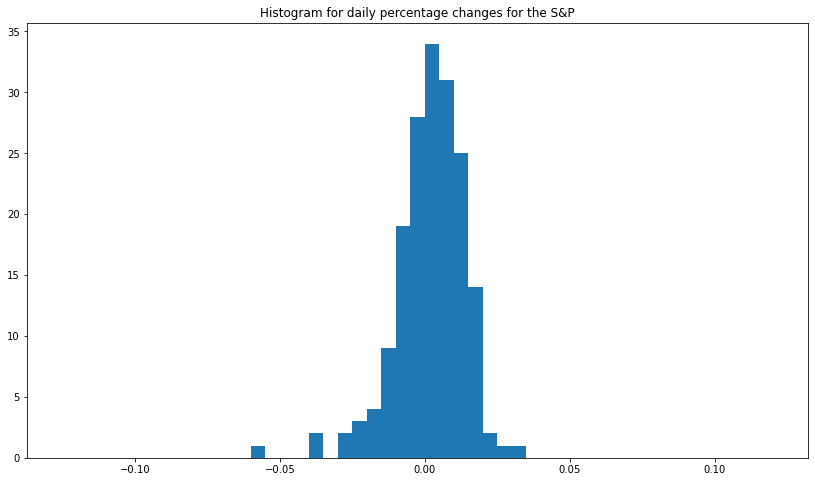

In [14]:
# Graph all trends in absolute terms
plt.figure(figsize=(14,5))
plt.plot(df_closing_prices.Date, df_closing_prices.Close_GSPC, label = "GSPC")
plt.title('Historical prices for the S&P')
plt.show()

plt.figure(figsize=(14,5))
plt.plot(df_closing_prices.Date, df_closing_prices.Close_GSPC.diff(), label = "GSPC")
plt.title('Absolute daily differences for the S&P')
plt.show()

plt.figure(figsize=(14,5))
plt.plot(df_closing_prices.Date, df_closing_prices.Close_GSPC.pct_change(), label = "GSPC")
plt.title('Daily percentage changes for the S&P')
plt.show()

bins=np.arange(-0.125,0.125,0.005)
plt.figure(figsize=(14,8))
plt.hist(df_closing_prices.Close_GSPC.pct_change(), label = "GSPC", bins=bins)
plt.title('Histogram for daily percentage changes for the S&P')
plt.show()

The graphs above serve as one last visual tool to understand the nature of the returns we will be working with

<Figure size 648x432 with 0 Axes>

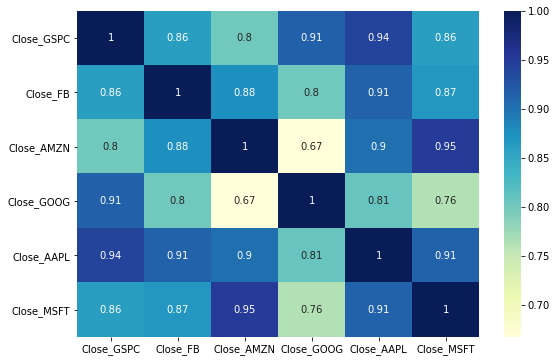

In [15]:
#Correlation matrix for variables, first make a smaller dataframe with numerical values only
plt.figure(figsize=(9,6))
df_for_corr_matrix = df_closing_prices
corr = df_for_corr_matrix.corr()
ax = sns.heatmap(corr,cmap="YlGnBu", annot=True)

The correlation matrix above is a great indicator of the correlations that our constituents have with the S&P 500. The high degree of correlation is a great indicator that these variables are likely to have high predictive power over the closing price of the S&P 500

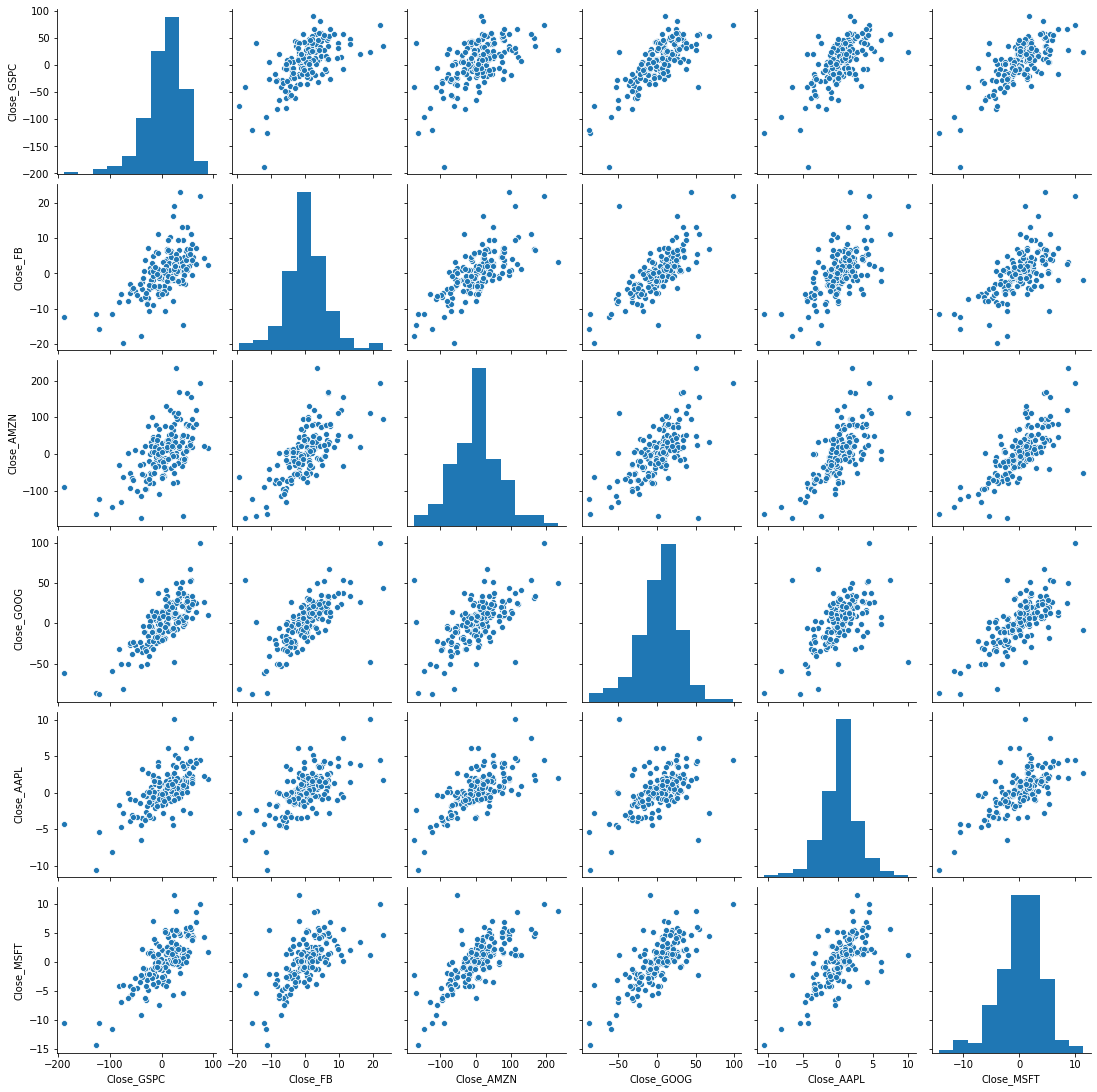

In [16]:
# Plot the pair plot for absolute differences
sns.pairplot(df_for_corr_matrix.diff())

,Close_GSPC,Close_FB,Close_AMZN,Close_GOOG,Close_AAPL,Close_MSFT
Date,,,,,,
2020-05-01,2830.709961,202.270004,2286.040039,1320.609985,72.267502,174.570007
2020-05-04,2842.739990,205.259995,2315.989990,1326.800049,73.290001,178.839996
2020-05-05,2868.439941,207.070007,2317.800049,1351.109985,74.389999,180.759995
2020-05-06,2848.419922,208.470001,2351.260010,1347.300049,75.157501,182.539993
2020-05-07,2881.189941,211.259995,2367.610107,1372.560059,75.934998,183.600006


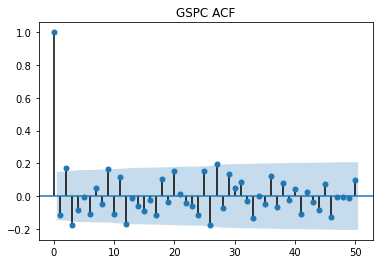

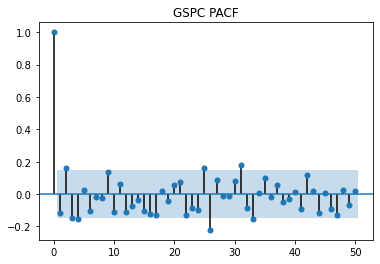

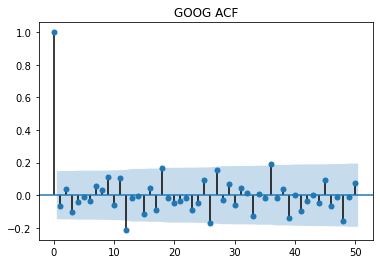

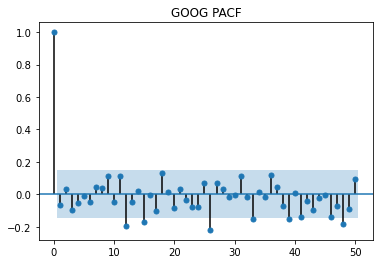

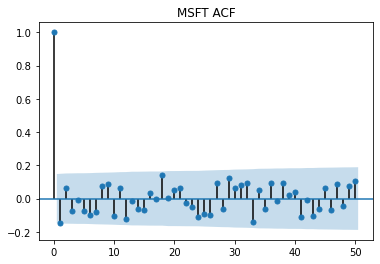

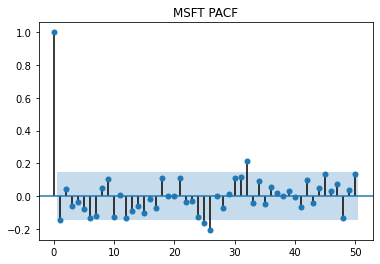

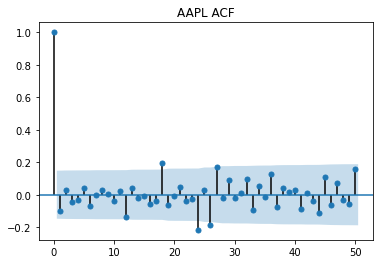

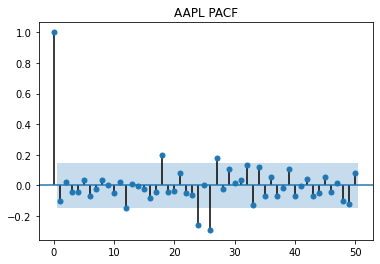

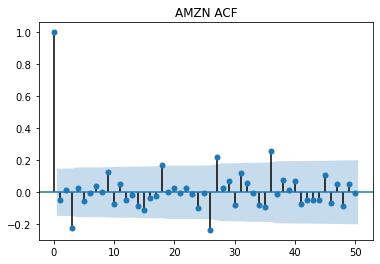

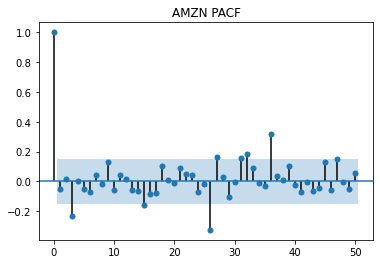

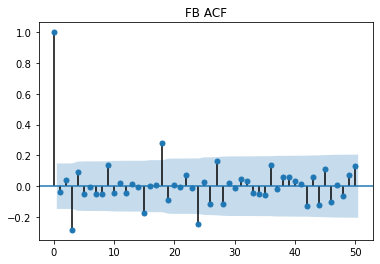

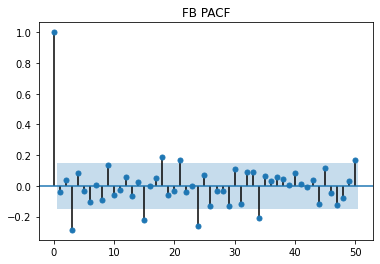

In [17]:
from statsmodels.graphics.tsaplots import plot_acf as plot_acf
from statsmodels.graphics.tsaplots import plot_pacf as plot_pacf

#the ACF plots only work with time series data so I need to see only the confirmed variable, note the axis is date time
df_closing_prices_DATE = df_closing_prices.set_index('Date')
df_closing_prices_DATE.head()

df_GSPC_P = df_closing_prices_DATE['Close_GSPC']
df_GSPC_acf = plot_acf(df_GSPC_P.diff().dropna(), alpha=0.05, lags=50, title='GSPC ACF')
df_GSPC_pacf = plot_pacf(df_GSPC_P.diff().dropna(), alpha=0.05, lags=50, title='GSPC PACF')

df_GOOG_P = df_closing_prices_DATE['Close_GOOG']
df_GOOG_acf = plot_acf(df_GOOG_P.diff().dropna(), alpha=0.05, lags=50, title='GOOG ACF')
df_GOOG_pacf = plot_pacf(df_GOOG_P.diff().dropna(), alpha=0.05, lags=50, title='GOOG PACF')

df_MSFT_P = df_closing_prices_DATE['Close_MSFT']
df_MSFT_acf = plot_acf(df_MSFT_P.diff().dropna(), alpha=0.05, lags=50, title='MSFT ACF')
df_MSFT_pacf = plot_pacf(df_MSFT_P.diff().dropna(), alpha=0.05, lags=50, title='MSFT PACF')

df_AAPL_P = df_closing_prices_DATE['Close_AAPL']
df_AAPL_acf = plot_acf(df_AAPL_P.diff().dropna(), alpha=0.05, lags=50, title='AAPL ACF')
df_AAPL_pacf = plot_pacf(df_AAPL_P.diff().dropna(), alpha=0.05, lags=50, title='AAPL PACF')

df_AMZN_P = df_closing_prices_DATE['Close_AMZN']
df_AMZN_acf = plot_acf(df_AMZN_P.diff().dropna(), alpha=0.05, lags=50, title='AMZN ACF')
df_AMZN_pacf = plot_pacf(df_AMZN_P.diff().dropna(), alpha=0.05, lags=50, title='AMZN PACF')

df_FB_P = df_closing_prices_DATE['Close_FB']
df_FB_acf = plot_acf(df_FB_P.diff().dropna(), alpha=0.05, lags=50, title='FB ACF')
df_FB_pacf = plot_pacf(df_FB_P.diff().dropna(), alpha=0.05, lags=50, title='FB PACF')



### Conclusions so far
By looking at the line graph for each one of the top 5 constituents of the S&P as well as for the index itself, we can see these variables are very co-dependent. These relationships are further evidenced by the correlations displayed in the correlation matrix heatmap. 

Additionally, by looking at the distribution of returns in both the line graph and the histogram we can see that the distribution of returns appear to be normally distributed with a mean around 0 which is a great set of features to fit autoregressive models such as ARIMA and VAR. 

As it relates to ARIMA and VAR, given that this data has been differenced once we can say that we should be performing 1 differentiation of the data to fit any autoregressive models, since stationarity is only reached once the data has been differenced once. 

Additionally, as it relates to the values of p and q for AR(p) and MA(q), we should be specifying our model as AR(0), since the PACF graph does not have any other salient partial autocorrelation nodes beyond the first one (which isn't counted). While, simultaneously specifying our model as MA(0) since there are no salient negative nodes in the PACF graph. 

## 05 Preprocessing & Feature Engineering
Since the data for this forecast is pretty clean and we can use the opening prices for all stocks and the index as a lagged variable, there is no need to perform any feature engineering or scaling before fitting any of the models. The only item to address for each model is feature selection.   


## 06 Model Evaluation

### 06_01 ARIMA Model
Auto Regressive Integrated Moving Average (ARIMA) - Each of these components are explicitly specified in the model as a parameter. A standard notation of ARIMA(p,d,q) is used where the parameters are substituted with integer values to quickly indicate the specific ARIMA model being used. Where p, indicates the regression AR(p) criteria d, indicates the differentiation criteria and q, indicates the moving average criteria MA(q)

p: The number of lag observations included in the model, also called the lag order.

d: The number of times that the raw observations are differenced, also called the degree of differencing.

q: The size of the moving average window, also called the order of moving average.

In [18]:
# We setup X equal to the S&P closing prices and set the index equal to the data for the ARIMA model
X = df_closing_prices[['Date','Close_GSPC']]
X['Date'] = pd.to_datetime(X.iloc[:,0])
X = X.set_index('Date')
# Without specifying the line of code below, my forecasting model will not yield results 
# This is a crucial step to avoid exceptions
X.index = pd.DatetimeIndex(X.index).to_period('D')
X = X.dropna()
X.head()

<ipython-input-18-0cef13de90f6>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Date'] = pd.to_datetime(X.iloc[:,0])


,Close_GSPC
Date,
2020-05-01,2830.709961
2020-05-04,2842.739990
2020-05-05,2868.439941
2020-05-06,2848.419922
2020-05-07,2881.189941


We wil split our data into training and test sets so that we will be able to perform model evaluations later on

In [19]:
# Make train and test variables, with 'train, test'
split= int(len(X) * 0.90) 
X_train, X_test = X[0:split], X[split:len(X)]

In [20]:
# Specify ARIMA model
from datetime import datetime
from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(X_train, order=(0,1,0))
model_fit = model.fit()
last_train_value = X_train.index[-1]
start_index = model_fit.predict().index[0]
end_index = X.index[-1]
predicted_values = model_fit.predict(start=start_index, end=end_index)
last_train_value
start_index
end_index
predicted_values.head()
predicted_values.tail()

Period('2020-12-15', 'D')

Period('2020-05-04', 'D')

Period('2021-01-12', 'D')

2020-05-04    5.467786
2020-05-05    5.467786
2020-05-06    5.467786
2020-05-07    5.467786
2020-05-08    5.467786
Freq: D, dtype: float64

2021-01-08    5.467786
2021-01-09    5.467786
2021-01-10    5.467786
2021-01-11    5.467786
2021-01-12    5.467786
Freq: D, dtype: float64

In [21]:
# The forecast will give me values for non-trading dates along with trading dates, therefore I first need to remove all /
# the rows of data that do not have any trading dates
X_for_cleaning = X.reset_index()
predicted_values = predicted_values.reset_index()
predicted_values.columns = ['Date','Close_GSPC_Forecast']
pred_and_X = X_for_cleaning.merge(predicted_values, how='left', on='Date')
pred_and_X = pred_and_X.set_index('Date')
pred_and_X = pred_and_X['Close_GSPC_Forecast'].dropna()
predicted_values = pred_and_X

# Undifference the data to create a time series once again
initial_value = df_closing_prices['Close_GSPC'][0]
initial_date = df_closing_prices['Date'][0]

ARIMA_output = list()
ARIMA_output.insert(0, initial_value)
y = initial_value
for x in predicted_values:
    y = y + x
    ARIMA_output.append(y)
    
ARIMA_output = [i for i in ARIMA_output]
ARIMA_output = pd.DataFrame(ARIMA_output, columns=['Close_GSPC_Forecast'])
ARIMA_output['Date'] = df_closing_prices['Date']
ARIMA_output.head()
ARIMA_output.tail(40)
df_closing_prices.head()
df_closing_prices.tail(40)

,Close_GSPC_Forecast,Date
0,2830.709961,2020-05-01
1,2836.177747,2020-05-04
2,2841.645533,2020-05-05
3,2847.113318,2020-05-06
4,2852.581104,2020-05-07


,Close_GSPC_Forecast,Date
137,3579.796615,2020-11-13
138,3585.264401,2020-11-16
139,3590.732187,2020-11-17
140,3596.199973,2020-11-18
141,3601.667758,2020-11-19
142,3607.135544,2020-11-20
143,3612.603330,2020-11-23
144,3618.071116,2020-11-24
145,3623.538902,2020-11-25
146,3629.006687,2020-11-27


,Date,Close_GSPC,Close_FB,Close_AMZN,Close_GOOG,Close_AAPL,Close_MSFT
0,2020-05-01,2830.709961,202.270004,2286.040039,1320.609985,72.267502,174.570007
1,2020-05-04,2842.739990,205.259995,2315.989990,1326.800049,73.290001,178.839996
2,2020-05-05,2868.439941,207.070007,2317.800049,1351.109985,74.389999,180.759995
3,2020-05-06,2848.419922,208.470001,2351.260010,1347.300049,75.157501,182.539993
4,2020-05-07,2881.189941,211.259995,2367.610107,1372.560059,75.934998,183.600006


,Date,Close_GSPC,Close_FB,Close_AMZN,Close_GOOG,Close_AAPL,Close_MSFT
137,2020-11-13,3585.149902,276.950012,3128.810059,1777.020020,119.260002,216.509995
138,2020-11-16,3626.909912,278.959991,3131.060059,1781.380005,120.300003,217.229996
139,2020-11-17,3609.530029,275.000000,3135.659912,1770.150024,119.389999,214.460007
140,2020-11-18,3567.790039,271.970001,3105.459961,1746.780029,118.029999,211.080002
141,2020-11-19,3581.870117,272.940002,3117.020020,1763.920044,118.639999,212.419998
142,2020-11-20,3557.540039,269.700012,3099.399902,1742.189941,117.339996,210.389999
143,2020-11-23,3577.590088,268.429993,3098.389893,1734.859985,113.849998,210.110001
144,2020-11-24,3635.409912,276.920013,3118.060059,1768.880005,115.169998,213.860001
145,2020-11-25,3629.649902,275.589996,3185.070068,1771.430054,116.029999,213.869995
146,2020-11-27,3638.350098,277.809998,3195.340088,1793.189941,116.589996,215.229996


<Figure size 1008x576 with 0 Axes>

Text(0.5, 1.0, 'ARIMA Forecast vs S&P Actual')

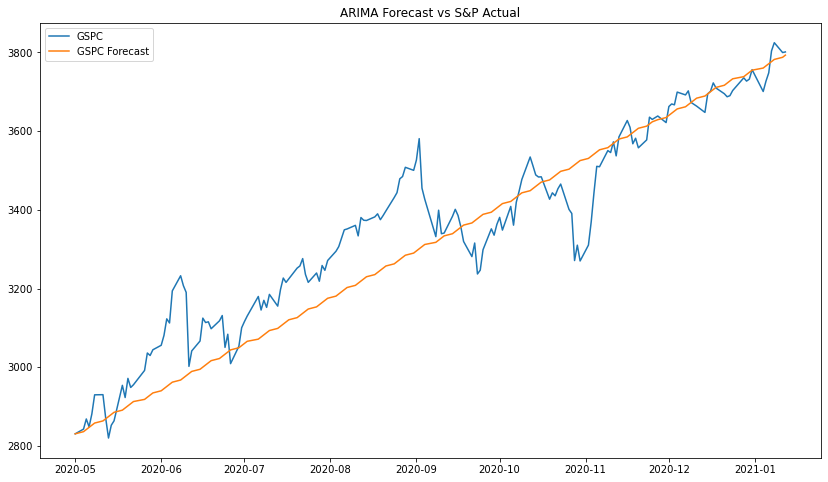

In [22]:
plt.figure(figsize=(14,8))
plt.plot(df_closing_prices.Date, df_closing_prices.Close_GSPC, label = "GSPC")
plt.plot(ARIMA_output.Date, ARIMA_output.Close_GSPC_Forecast, label = "GSPC Forecast")
plt.legend(loc="upper left")
plt.title('ARIMA Forecast vs S&P Actual')
plt.show()

As it can be seen our ARIMA model which is in practice a 'once difference' model since we set it up as an AR(0) and MA(0) model gives us a rather straight line as a forecast which appears to be very close to the overall trend the index has been following. With that said, there should be room for improvement. 

In [23]:
# Merge both dataframes to perform scoring 
ARIMA_for_calcs = ARIMA_output.merge(df_closing_prices[['Date','Close_GSPC']], how='inner', on='Date')
ARIMA_for_calcs = ARIMA_for_calcs.set_index('Date')
ARIMA_for_calcs.head()
str(last_train_value)

,Close_GSPC_Forecast,Close_GSPC
Date,,
2020-05-01,2830.709961,2830.709961
2020-05-04,2836.177747,2842.739990
2020-05-05,2841.645533,2868.439941
2020-05-06,2847.113318,2848.419922
2020-05-07,2852.581104,2881.189941


'2020-12-15'

In [24]:
#Model Scoring MAD = Mean Absolute Deviation MAPE = Mean absolute percentage error
ARIMA_for_calcs = ARIMA_for_calcs[ARIMA_for_calcs.index>str(last_train_value)]
ARIMA_for_calcs['MAD'] = np.abs(ARIMA_for_calcs['Close_GSPC']-ARIMA_for_calcs['Close_GSPC_Forecast'])
ARIMA_for_calcs['MAPE'] = np.abs((ARIMA_for_calcs['Close_GSPC']-ARIMA_for_calcs['Close_GSPC_Forecast'])/ARIMA_for_calcs['Close_GSPC'])
MAD = np.mean(ARIMA_for_calcs['MAD'])
MAPE = np.mean(ARIMA_for_calcs['MAPE'])
print('The MAD for the forecast was: '+str(int(MAD)))
print('The MAPE for the forecast was: '+'{:.1%}'.format(MAPE))

The MAD for the forecast was: 21
The MAPE for the forecast was: 0.6%


Our model performance for our test set was overall very satisfactor with a MAPE of 0.6%, it could be argued that this is a valuable model to perform our forecasts. Let's see if we can achieve better results with our next two models!

## 06_02 VAR Model
We can use a Vector Autoregression (VAR) model if we determine that there are other variables that are cointegrated with our dependent variable (the S&P index). Intuitively, since our independent variables are constituents of the index we expect them to show cointegration. However, before modeling this scenario, we will perform a test for cointegration. 

In [25]:
#importing packages for this analysis
from statsmodels.tsa.api import VAR
from statsmodels.tools.eval_measures import rmse, aic

In [26]:
# To perform a test for cointegration we will use the coint module in statsmodels 
# The confidence levels and statistics for cointegration tests are the follow:
# Significance and Critical Values (1%:-4.645, 5%:-4.157, 10%:-3.843)
import statsmodels.tsa.stattools as ts
GSPCxFB_coint = ts.coint(df_closing_prices_DATE['Close_GSPC'].diff().dropna(),df_closing_prices_DATE['Close_FB'].diff().dropna())
GSPCxFB_coint = [x for x in GSPCxFB_coint]
print('The cointegration statistic is for FB '+str(GSPCxFB_coint[0]))
GSPCxGOOG_coint = ts.coint(df_closing_prices_DATE['Close_GSPC'].diff().dropna(),df_closing_prices_DATE['Close_GOOG'].diff().dropna())
GSPCxGOOG_coint = [x for x in GSPCxGOOG_coint]
print('The cointegration statistic is for GOOG '+str(GSPCxGOOG_coint[0]))
GSPCxAMZN_coint = ts.coint(df_closing_prices_DATE['Close_AMZN'].diff().dropna(),df_closing_prices_DATE['Close_AMZN'].diff().dropna())
GSPCxAMZN_coint = [x for x in GSPCxAMZN_coint]
print('The cointegration statistic is for AMZN '+str(GSPCxAMZN_coint[0]))
GSPCxAAPL_coint = ts.coint(df_closing_prices_DATE['Close_AAPL'].diff().dropna(),df_closing_prices_DATE['Close_AAPL'].diff().dropna())
GSPCxAAPL_coint = [x for x in GSPCxAAPL_coint]
print('The cointegration statistic is for AAPL '+str(GSPCxAAPL_coint[0]))
GSPCxMSFT_coint = ts.coint(df_closing_prices_DATE['Close_MSFT'].diff().dropna(),df_closing_prices_DATE['Close_MSFT'].diff().dropna())
GSPCxMSFT_coint = [x for x in GSPCxMSFT_coint]
print('The cointegration statistic is for MSFT '+str(GSPCxMSFT_coint[0]))


The cointegration statistic is for FB -14.137214223943847
The cointegration statistic is for GOOG -13.650045258277611
The cointegration statistic is for AMZN -inf
The cointegration statistic is for AAPL -inf
The cointegration statistic is for MSFT -inf


C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1396: CollinearityWarning: y0 and y1 are (almost) perfectly colinear.Cointegration test is not reliable in this case.
  warnings.warn("y0 and y1 are (almost) perfectly colinear."
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1396: CollinearityWarning: y0 and y1 are (almost) perfectly colinear.Cointegration test is not reliable in this case.
  warnings.warn("y0 and y1 are (almost) perfectly colinear."
C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1396: CollinearityWarning: y0 and y1 are (almost) perfectly colinear.Cointegration test is not reliable in this case.
  warnings.warn("y0 and y1 are (almost) perfectly colinear."


Given that all the variables have large cointegration statistics well beyond the critical value at 1% of significance (-4.645), we will use all 5 variables in our VAR model. 

In [27]:
# These are the variables
differenced_data = df_closing_prices_DATE.diff().dropna()
differenced_data.head()

,Close_GSPC,Close_FB,Close_AMZN,Close_GOOG,Close_AAPL,Close_MSFT
Date,,,,,,
2020-05-04,12.030029,2.989991,29.949951,6.190064,1.022499,4.269989
2020-05-05,25.699951,1.810012,1.810059,24.309936,1.099998,1.919999
2020-05-06,-20.020019,1.399994,33.459961,-3.809936,0.767502,1.779998
2020-05-07,32.770019,2.789994,16.350097,25.260010,0.777497,1.060013
2020-05-08,48.610108,1.090011,12.000000,15.809936,1.597503,1.079987


In [28]:
# Specify our training and test data
from datetime import date
f_date = last_train_value
l_date = end_index
constant = '86400000000000'
delta = (l_date - f_date)/constant


VAR_data = differenced_data
nobs = int(delta*1)
df_train, df_test = VAR_data[0:-nobs], VAR_data[-nobs:]


#Specify the model and run the different parameters to find the optimal parameters
model = VAR(VAR_data)
for i in [1,2,3,4,5,6,7,8,9,10,11,12,13]:
    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')
    
x = model.select_order(maxlags=12)
x.summary()

Lag Order = 1
AIC :  26.140193619793
BIC :  26.899742253534644
FPE :  225243948154.25516
HQIC:  26.448288178486173 

Lag Order = 2
AIC :  26.36916730314951
BIC :  27.785295540728434
FPE :  283602966082.3933
HQIC:  26.94363594145279 

Lag Order = 3
AIC :  26.4780032878761
BIC :  28.55589485881683
FPE :  317372128862.6734
HQIC:  27.3209913188386 

Lag Order = 4
AIC :  26.58447890584526
BIC :  29.329386879810478
FPE :  355545729092.6364
HQIC:  27.698159290034138 

Lag Order = 5
AIC :  26.848811166774453
BIC :  30.266059245777345
FPE :  468651012704.87366
HQIC:  28.235384988746365 

Lag Order = 6
AIC :  26.992300648582013
BIC :  31.087284489906473
FPE :  550864077828.5581
HQIC:  28.653997603286438 

Lag Order = 7
AIC :  27.158567646576884
BIC :  31.93675621728785
FPE :  667723107640.6609
HQIC:  29.09764653591983 

Lag Order = 8
AIC :  27.354565590610267
BIC :  32.82150255456597
FPE :  842137174652.5918
HQIC:  29.573314830411746 

Lag Order =

C:\Users\MarceloFuentes\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


 9
AIC :  27.529067240415912
BIC :  33.69037237872447
FPE :  1052345391731.7615
HQIC:  30.029805377999672 

Lag Order = 10
AIC :  27.84076076949514
BIC :  34.70213143538969
FPE :  1531180648168.1433
HQIC:  30.625837012153994 

Lag Order = 11
AIC :  27.848157394827098
BIC :  35.41537000396669
FPE :  1673685973797.0967
HQIC:  30.91995214941243 

Lag Order = 12
AIC :  27.893063908767026
BIC :  36.171975466004824
FPE :  1942125876838.5452
HQIC:  31.253989332655955 

Lag Order = 13
AIC :  27.754753478942234
BIC :  36.75130314263797
FPE :  1928045907113.7405
HQIC:  31.40725404264102 



,AIC,BIC,FPE,HQIC
0,26.26*,26.37*,2.540e+11*,26.31*
1,26.33,27.13,2.727e+11,26.65
2,26.53,28.01,3.348e+11,27.13
3,26.66,28.81,3.811e+11,27.53
4,26.75,29.59,4.204e+11,27.90
5,27.00,30.52,5.485e+11,28.43
6,27.12,31.32,6.302e+11,28.83
7,27.28,32.15,7.557e+11,29.26
8,27.43,32.99,9.192e+11,29.69
9,27.57,33.80,1.101e+12,30.10


Based on the analysis above, the AIC (Akaike information criterion) and BIC (Bayesian information criterion) were at their lowest levels on Lag = 0. However, a VAR model must be specified with at least a lag of 1, since at its name describes it is an "auto-regression" model, which implies having a lag. Therefore with that said, we will specify this model with an order of Lag = 1.

In [29]:
#The fitted model with a lag of 1 is specified as follows
model_fitted = model.fit(1)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 15, Jan, 2021
Time:                     21:51:30
--------------------------------------------------------------------
No. of Equations:         6.00000    BIC:                    26.8997
Nobs:                     175.000    HQIC:                   26.4483
Log likelihood:          -3735.15    FPE:                2.25244e+11
AIC:                      26.1402    Det(Omega_mle):     1.78014e+11
--------------------------------------------------------------------
Results for equation Close_GSPC
                   coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------
const                 5.689893         2.982347            1.908           0.056
L1.Close_GSPC         0.070754         0.133138            0.531           0.595
L1.Close_FB           0.210608         0.762305        

In [30]:
#The next step will be to perform a Durbin-Watson test to check if the residuals have any unexplained variance.
from statsmodels.stats.stattools import durbin_watson
out = durbin_watson(model_fitted.resid)

for col, val in zip(VAR_data.columns, out):
    print(col, ':', round(val, 2))

Close_GSPC : 1.98
Close_FB : 2.0
Close_AMZN : 1.98
Close_GOOG : 2.01
Close_AAPL : 1.93
Close_MSFT : 1.97


The Durbin-Watson statistic will always assume a value between 0 and 4. A value of DW = 2 indicates there is no autocorrelation. When the value is below 2, it indicates a positive autocorrelation, and a value higher than 2 indicates a negative serial correlation. In this case, the correlations look good, although with a bit of a positive autocorrelation.

In [31]:
# Get the lag order
lag_order = model_fitted.k_ar
print(lag_order)  #> 1
steps = lag_order

# Input data for forecasting
forecast_input = VAR_data.values[-lag_order:]
forecast_input

1


array([[  1.579834,  -5.75    ,   6.620117, -20.169922,  -0.179993,
         -2.560012]])

In [32]:
# Forecast
fc = model_fitted.forecast(y=forecast_input, steps=nobs)
df_VAR_forecast = pd.DataFrame(fc, index=VAR_data.index[-nobs:], columns=VAR_data.columns + '_2d')
len(df_VAR_forecast)
df_VAR_forecast.head(30)

28

,Close_GSPC_2d,Close_FB_2d,Close_AMZN_2d,Close_GOOG_2d,Close_AAPL_2d,Close_MSFT_2d
Date,,,,,,
2020-12-02,10.973785,1.786576,9.320240,6.496579,0.679513,0.521505
2020-12-03,5.371315,0.198478,4.198221,2.718574,0.264529,0.331742
2020-12-04,5.222260,0.224446,4.438041,2.128892,0.307651,0.147129
2020-12-07,5.676068,0.290345,4.669882,2.532390,0.326638,0.225940
2020-12-08,5.529898,0.269378,4.605973,2.440683,0.317409,0.208727
2020-12-09,5.553767,0.272769,4.607890,2.449722,0.319357,0.210285
2020-12-10,5.553755,0.272638,4.610766,2.451318,0.319196,0.210645
2020-12-11,5.552565,0.272527,4.609759,2.450370,0.319149,0.210440
2020-12-14,5.552973,0.272571,4.609927,2.450612,0.319172,0.210492


In [33]:
df_results = df_VAR_forecast

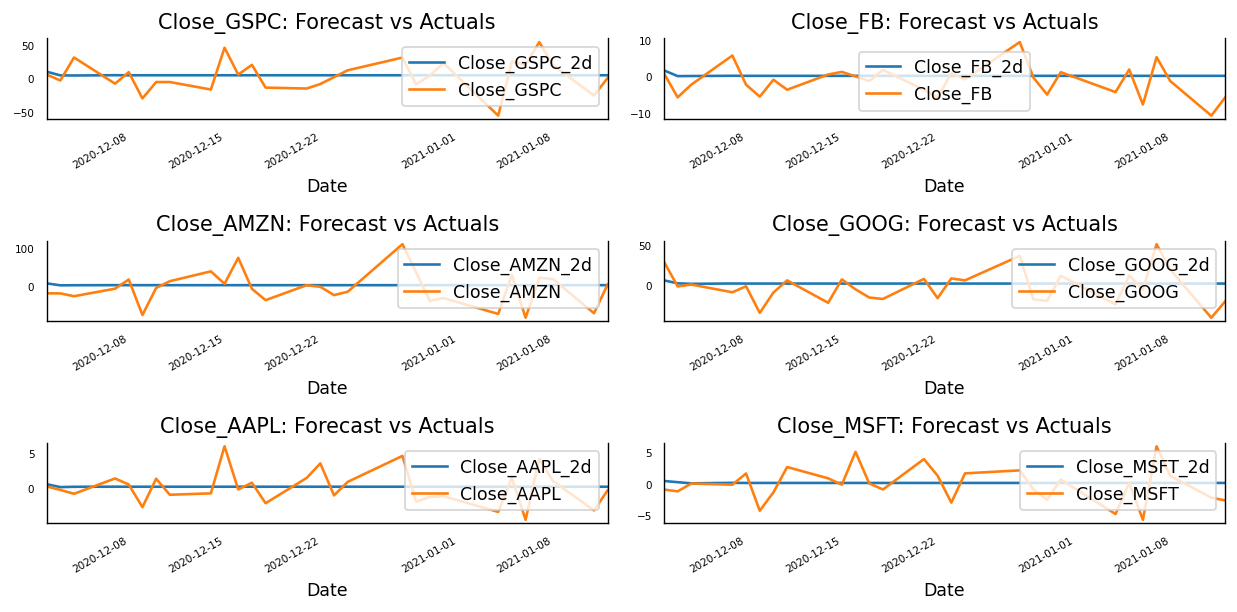

In [34]:
# Plot of Forecast vs Actuals
fig, axes = plt.subplots(nrows=int(len(VAR_data.columns)/2), ncols=2, dpi=125, figsize=(10,5))
for i, (col,ax) in enumerate(zip(VAR_data.columns, axes.flatten())):
    df_results[col+'_2d'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    df_test[col][-nobs:].plot(legend=True, ax=ax);
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

Similar to the results we obtained using our ARIMA model, these trend lines appear to be very close to the overall performance of the index which is a good indicator, we will calculate MAPE and MAD next to understand our level of accuracy relative to ARIMA.

In [35]:
#Dataframe for MAD and MAPE analyses 
VAR_for_plots = df_test.merge(df_results, how='left', left_on='Date',right_on='Date')

In [36]:
#Reduce the data frame to use only the VAR and actual values 
VAR_for_plots_GSPC = VAR_for_plots[['Close_GSPC','Close_GSPC_2d']]
VAR_for_plots_GSPC.head()

,Close_GSPC,Close_GSPC_2d
Date,,
2020-12-02,6.560059,10.973785
2020-12-03,-2.290039,5.371315
2020-12-04,32.400146,5.222260
2020-12-07,-7.160156,5.676068
2020-12-08,10.290039,5.529898


In [37]:
#Bring the initial value to compute the undifferenced data 
VAR_initial_value = df_closing_prices[['Date','Close_GSPC']][df_closing_prices['Date']==VAR_for_plots_GSPC.index[0]]
VAR_initial_value = VAR_initial_value.reset_index(drop=True) 
VAR_initial_value.head()
VAR_initial_value_GSPC = VAR_initial_value['Close_GSPC'][0]
VAR_initial_date_GSPC = VAR_initial_value['Date'][0]

,Date,Close_GSPC
0,2020-12-02,3669.01001


In [38]:
#Use the loop below to undifference data
# Undifference the data to create a time series once again

initial_value = VAR_initial_value_GSPC

VAR_output = list()
y = initial_value - VAR_for_plots_GSPC['Close_GSPC_2d'][0]
for x in VAR_for_plots_GSPC['Close_GSPC_2d']:
        y = y + x
        VAR_output.append(y)
    

VAR_output = [i for i in VAR_output]
VAR_output = pd.DataFrame(VAR_output, columns=['Close_GSPC_VAR_Forecast'])
VAR_output['Date'] = VAR_for_plots.index
VAR_output.head()
VAR_output.tail(40)
df_closing_prices.head()
df_closing_prices.tail(40)

,Close_GSPC_VAR_Forecast,Date
0,3669.010010,2020-12-02
1,3674.381325,2020-12-03
2,3679.603585,2020-12-04
3,3685.279652,2020-12-07
4,3690.809550,2020-12-08


,Close_GSPC_VAR_Forecast,Date
0,3669.010010,2020-12-02
1,3674.381325,2020-12-03
2,3679.603585,2020-12-04
3,3685.279652,2020-12-07
4,3690.809550,2020-12-08
5,3696.363318,2020-12-09
6,3701.917073,2020-12-10
7,3707.469638,2020-12-11
8,3713.022611,2020-12-14
9,3718.575505,2020-12-15


,Date,Close_GSPC,Close_FB,Close_AMZN,Close_GOOG,Close_AAPL,Close_MSFT
0,2020-05-01,2830.709961,202.270004,2286.040039,1320.609985,72.267502,174.570007
1,2020-05-04,2842.739990,205.259995,2315.989990,1326.800049,73.290001,178.839996
2,2020-05-05,2868.439941,207.070007,2317.800049,1351.109985,74.389999,180.759995
3,2020-05-06,2848.419922,208.470001,2351.260010,1347.300049,75.157501,182.539993
4,2020-05-07,2881.189941,211.259995,2367.610107,1372.560059,75.934998,183.600006


,Date,Close_GSPC,Close_FB,Close_AMZN,Close_GOOG,Close_AAPL,Close_MSFT
137,2020-11-13,3585.149902,276.950012,3128.810059,1777.020020,119.260002,216.509995
138,2020-11-16,3626.909912,278.959991,3131.060059,1781.380005,120.300003,217.229996
139,2020-11-17,3609.530029,275.000000,3135.659912,1770.150024,119.389999,214.460007
140,2020-11-18,3567.790039,271.970001,3105.459961,1746.780029,118.029999,211.080002
141,2020-11-19,3581.870117,272.940002,3117.020020,1763.920044,118.639999,212.419998
142,2020-11-20,3557.540039,269.700012,3099.399902,1742.189941,117.339996,210.389999
143,2020-11-23,3577.590088,268.429993,3098.389893,1734.859985,113.849998,210.110001
144,2020-11-24,3635.409912,276.920013,3118.060059,1768.880005,115.169998,213.860001
145,2020-11-25,3629.649902,275.589996,3185.070068,1771.430054,116.029999,213.869995
146,2020-11-27,3638.350098,277.809998,3195.340088,1793.189941,116.589996,215.229996


<Figure size 1008x576 with 0 Axes>

Text(0.5, 1.0, 'VAR Forecast vs S&P Actual')

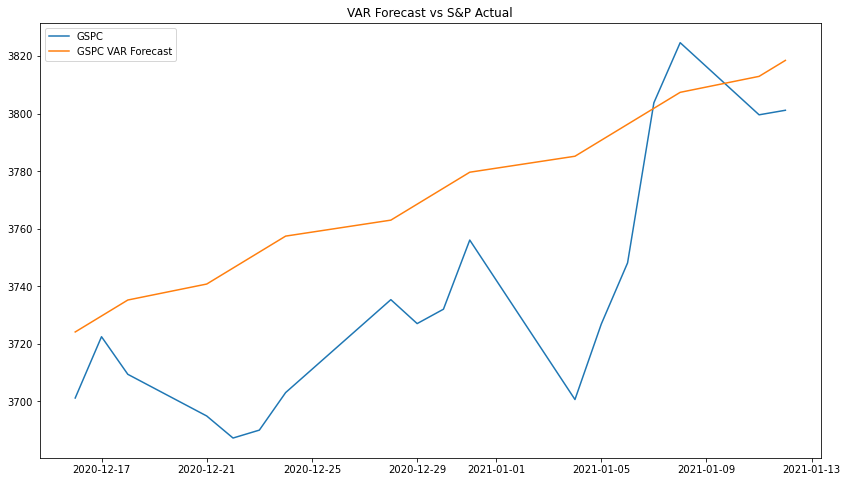

In [39]:
#Dataframe for MAD and MAPE analyses 
VAR_for_plots_agg = VAR_output.merge(df_closing_prices[['Date','Close_GSPC']], how='left', on='Date')
VAR_for_plots_agg = VAR_for_plots_agg[VAR_for_plots_agg['Date']>'2020-12-15']

plt.figure(figsize=(14,8))
plt.plot(VAR_for_plots_agg.Date, VAR_for_plots_agg.Close_GSPC, label = "GSPC")
plt.plot(VAR_for_plots_agg.Date, VAR_for_plots_agg.Close_GSPC_VAR_Forecast, label = "GSPC VAR Forecast")
plt.legend(loc="upper left")
plt.title('VAR Forecast vs S&P Actual')
plt.show()

In [40]:
# Model Scoring MAD = Mean Absolute Deviation MAPE = Mean absolute percentage error
VAR_for_plots_agg['MAD'] = np.abs(VAR_for_plots_agg['Close_GSPC']-VAR_for_plots_agg['Close_GSPC_VAR_Forecast'])
VAR_for_plots_agg['MAPE'] = np.abs((VAR_for_plots_agg['Close_GSPC']-VAR_for_plots_agg['Close_GSPC_VAR_Forecast'])/VAR_for_plots_agg['Close_GSPC'])
VAR_for_plots_agg = VAR_for_plots_agg.replace([np.inf, -np.inf], 0)
MAD = np.mean(VAR_for_plots_agg['MAD'])
MAPE = np.mean(VAR_for_plots_agg['MAPE'])
print('The MAD for the forecast was: '+str(int(MAD)))
print('The MAPE for the forecast was: '+'{:.1%}'.format(MAPE))

The MAD for the forecast was: 36
The MAPE for the forecast was: 1.0%


Unfortunately the output from our VAR(1) model appears to be inferior the results we obtained from our first model. With that said, this result is not surprising since our test of Partial Auto Correlation indicated that using a lag of one would not have been the best choice to model this data. However, it was valuable to see how an autoregression model would perform. 

## 06_03 Recursive Neural Network (Dense)
The last method we will use to forecast the S&P returns will be two recursive neural network with dense layers, which we will set up by using the sequential model. This model will be slightly more complex to set up but it might end up achieving better results than either the ARIMA or the VAR model.  

In [41]:
# First I need to bring in my variables
df.head()
df.columns
df_RNN = df[['Date','Close_GSPC', 'Open_AMZN', 'Open_AAPL', 'Open_GOOG', 'Open_FB', 'Open_MSFT', 'Open_GSPC']]

,Date,Open_GSPC,High_GSPC,Low_GSPC,Close_GSPC,Adj Close_GSPC,Volume_GSPC,ticker_GSPC,Open_AMZN,High_AMZN,...,Adj Close_FB,Volume_FB,ticker_FB,Open_MSFT,High_MSFT,Low_MSFT,Close_MSFT,Adj Close_MSFT,Volume_MSFT,ticker_MSFT
0,2020-05-01,2869.090088,2869.090088,2821.610107,2830.709961,2830.709961,4753160000,GSPC,2336.800049,2362.439941,...,202.270004,30415600,FB,175.800003,178.639999,174.009995,174.570007,173.211899,39370500,MSFT
1,2020-05-04,2815.010010,2844.239990,2797.850098,2842.739990,2842.739990,4723140000,GSPC,2256.379883,2326.979980,...,205.259995,19250700,FB,174.490005,179.000000,173.800003,178.839996,177.448639,30372900,MSFT
2,2020-05-05,2868.879883,2898.229980,2863.550049,2868.439941,2868.439941,5129590000,GSPC,2340.000000,2351.000000,...,207.070007,21071200,FB,180.619995,183.649994,179.899994,180.759995,179.353729,36839200,MSFT
3,2020-05-06,2883.139893,2891.110107,2847.649902,2848.419922,2848.419922,4861920000,GSPC,2329.439941,2357.449951,...,208.470001,21857000,FB,182.080002,184.199997,181.630005,182.539993,181.119873,32139300,MSFT
4,2020-05-07,2878.260010,2901.919922,2876.479980,2881.189941,2881.189941,5164640000,GSPC,2374.780029,2376.000000,...,211.259995,15152000,FB,184.169998,184.550003,182.580002,183.600006,182.171631,28316000,MSFT


Index(['Date', 'Open_GSPC', 'High_GSPC', 'Low_GSPC', 'Close_GSPC',
       'Adj Close_GSPC', 'Volume_GSPC', 'ticker_GSPC', 'Open_AMZN',
       'High_AMZN', 'Low_AMZN', 'Close_AMZN', 'Adj Close_AMZN', 'Volume_AMZN',
       'ticker_AMZN', 'Open_AAPL', 'High_AAPL', 'Low_AAPL', 'Close_AAPL',
       'Adj Close_AAPL', 'Volume_AAPL', 'ticker_AAPL', 'Open_GOOG',
       'High_GOOG', 'Low_GOOG', 'Close_GOOG', 'Adj Close_GOOG', 'Volume_GOOG',
       'ticker_GOOG', 'Open_FB', 'High_FB', 'Low_FB', 'Close_FB',
       'Adj Close_FB', 'Volume_FB', 'ticker_FB', 'Open_MSFT', 'High_MSFT',
       'Low_MSFT', 'Close_MSFT', 'Adj Close_MSFT', 'Volume_MSFT',
       'ticker_MSFT'],
      dtype='object')

Note that different from our VAR model, our RNN will be using the opening prices of the S&P Index. The reason we have decided to include this variable in our model is because it is a good proxy for a "lagged" variable in our model. Note that in a VAR(1) all the variables are regressed against a 1-day-lag version of themselves. 

In [42]:
# Now I need to import the packages needed to create a neural network
import keras
import tensorflow as tf
from keras.layers import Dense
from keras.layers import LSTM
from keras.models import Sequential
from keras.optimizers import SGD, Adam
from keras.callbacks import History

In [43]:
# Before setting up my model I need to reset the index back to a date
df_RNN = df_RNN.set_index('Date')

In [44]:
# I also need to split my data into training and set sets
X_complete = df_RNN.loc[:, df_RNN.columns != 'Close_GSPC']
y_complete = df_RNN['Close_GSPC']

split= int(len(X_complete) * 0.90) 
X_train, X_test = X_complete[0:split], X_complete[split:len(X_complete)]
y_train, y_test = y_complete[0:split], y_complete[split:len(y_complete)]

X_train = X_train.to_numpy()
X_test = X_test.to_numpy()
y_train = y_train.to_numpy()
y_test = y_test.to_numpy() 

In [45]:
# Now I can go ahead and set up my model

# First I need to specify the parameters for the model
n_cols = X_train.shape[1]
Learning_rates = [0.0015]
history = keras.callbacks.History()

# The loop was used to evaluate different learning rates which were specified above. The learning rate of 0.0015 was chosen.
for lr in Learning_rates:
    print('\n\nTesting model with learning rate: %f\n'%lr )
    
    # Build new model to test, unaffected by previous models
    model = Sequential()
    # We will use the sequential model
    model.add(Dense(50, activation='relu', input_shape = (n_cols,)))
    # We will specify our first layer with a relu activation function
    model.add(Dense(50, activation='relu'))
    model.add(Dense(1))  
    # Create SGD optimizer with specified learning rate: my_optimizer
    my_optimizer = Adam(lr=lr)
    
    # Compile the model
    model.compile(optimizer=my_optimizer, loss='mean_squared_error', metrics=['accuracy'])
    
    # Fit the model
    history_callback = model.fit(X_train, y_train, epochs=10000, callbacks=[history], verbose=0)
    loss_history = history_callback.history['loss']
    acc_history = history_callback.history['accuracy']
    #Scoring the model
    scores = model.evaluate(X_test, y_test)



Testing model with learning rate: 0.001500

1/1 [==============================] - 0s 270ms/step - loss: 515.1960 - accuracy: 0.0000e+00


In [46]:
# Now we can use our RNN model to predict our Y variable and compare it to our original output
y_pred = model(X_test)
y_pred = y_pred.numpy()

,y_pred,Date
0,3695.672852,2020-12-16
1,3712.668945,2020-12-17
2,3722.130859,2020-12-18
3,3683.174316,2020-12-21
4,3699.074707,2020-12-22


<Figure size 1008x576 with 0 Axes>

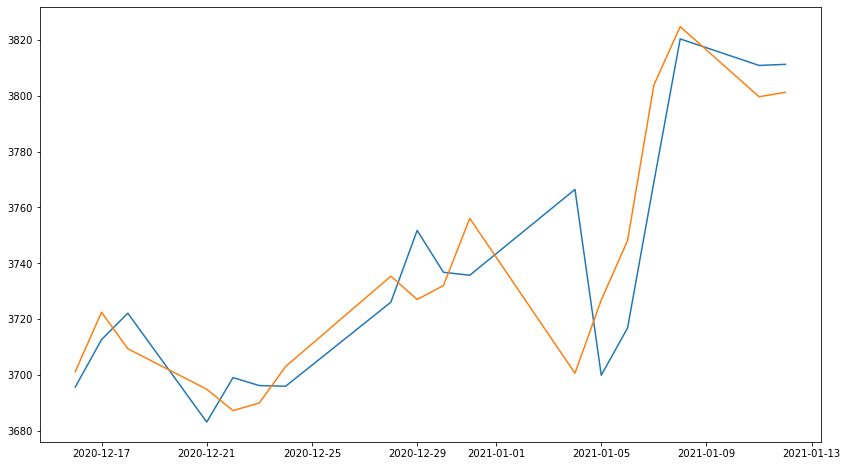

In [47]:
y_pred = pd.DataFrame(y_pred, columns=['y_pred'])
y_pred['Date'] = y_complete[split:len(y_complete)].index
y_test_graph = pd.DataFrame(y_test, columns=['y_test'])
y_test_graph['Date'] = y_complete[split:len(y_complete)].index
y_pred.head()
plt.figure(figsize=(14,8))
plt.plot(y_pred.Date,y_pred.y_pred)
plt.plot(y_pred.Date,y_test_graph.y_test)
plt.show()

In [48]:
# Make the full dataframe to calculate MAD & MAPE in the next cell
RNN_y_pred_and_test = y_pred
RNN_y_pred_and_test['y_test'] = y_test
RNN_y_pred_and_test = RNN_y_pred_and_test.set_index('Date')
RNN_y_pred_and_test

,y_pred,y_test
Date,,
2020-12-16,3695.672852,3701.169922
2020-12-17,3712.668945,3722.479980
2020-12-18,3722.130859,3709.409912
2020-12-21,3683.174316,3694.919922
2020-12-22,3699.074707,3687.260010
2020-12-23,3696.226074,3690.010010
2020-12-24,3695.994141,3703.060059
2020-12-28,3726.058838,3735.360107
2020-12-29,3751.748291,3727.040039


In [49]:
#Model Scoring MAD = Mean Absolute Deviation MAPE = Mean absolute percentage error
RNN_y_pred_and_test = RNN_y_pred_and_test[RNN_y_pred_and_test.index>str(last_train_value)]
RNN_y_pred_and_test['MAD'] = np.abs(RNN_y_pred_and_test['y_test']-RNN_y_pred_and_test['y_pred'])
RNN_y_pred_and_test['MAPE'] = np.abs((RNN_y_pred_and_test['y_test']-RNN_y_pred_and_test['y_pred'])/RNN_y_pred_and_test['y_test'])
MAD = np.mean(RNN_y_pred_and_test['MAD'])
MAPE = np.mean(RNN_y_pred_and_test['MAPE'])
print('The MAD for the forecast was: '+str(int(MAD)))
print('The MAPE for the forecast was: '+'{:.1%}'.format(MAPE))

The MAD for the forecast was: 17
The MAPE for the forecast was: 0.5%


## 07 Conclusion
The S&P index appears to be very tighly correlated to its top constituents, which for structural reasons is coherent. After tuning and fitting three different models, an ARIMA(0,1,0), a VAR(1) model and a Recursive Neural Network with Dense layers. The rankings in terms of predictive power are the following:

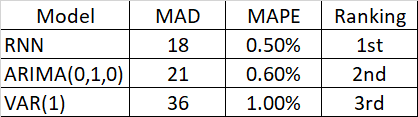

With that said, the datasets and methods by which all of these forecasts were performed were considerably different in nature. While ARIMA was fully dependent on the S&P Index returns time series, VAR dependended on multiple variables and the Lag(1) variables in the sample as well. Finally our Recursive Neural Network with Dense layers did not have an explicit lag variable, however in order to "embed" a lag into our model we used the opening prices for the S&P index in our model to be able to determine the closing price of the S&P every day. Note, that a big defficiency in both the ARIMA and VAR models is that they are dependent on the closing prices of both the index and its constituents in order to predict the price of the S&P, meanwhile our RNN is dependent only on the closing prices of the index along with the opening prices of their constituents, giving it even more value in our ranking. 

## 08 Discussion
Some of the limitations of this approach is that auto regression/regressive models do not perform well whenever one is working with non-stationary time series, therefore opening our training data to incorporate historical returns from multiple years ago could easily break one of the key assumptions needed for these models to converge. With that said, as it relates to our Neural Network, given its high performance an interesting study to consider in the future would be to model our RNN using a Long-Short Term Model which could yield higher results per some of the literature that I came across. I believe this study could prove of great value to Asset Managers, Risk Managers and all investors whenever they decide to peg their savings and/or retirement accounts to the S&P index or any of its variants. 